In [3]:
import sys
import pypsa
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

idx = pd.IndexSlice

In [4]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv', index_col=0)
plants = bmus.loc[bmus.carrier.str.contains('wind')].index

In [5]:
path = Path.cwd().parent / 'data' / 'base'
day_range = pd.date_range(start='2024-03-01', end='2024-03-31', freq='D')

bids = []

for day in day_range:
    bids.append(pd.read_csv(
        path / day.strftime('%Y-%m-%d') / 'bids.csv',
        index_col=[0,1], 
        parse_dates=True,
        ))

bids = pd.concat(bids)
bids = bids[plants.intersection(bids.columns)]
bids = bids.loc[idx[:,'vol'], :]
bids.index = bids.index.get_level_values(0)

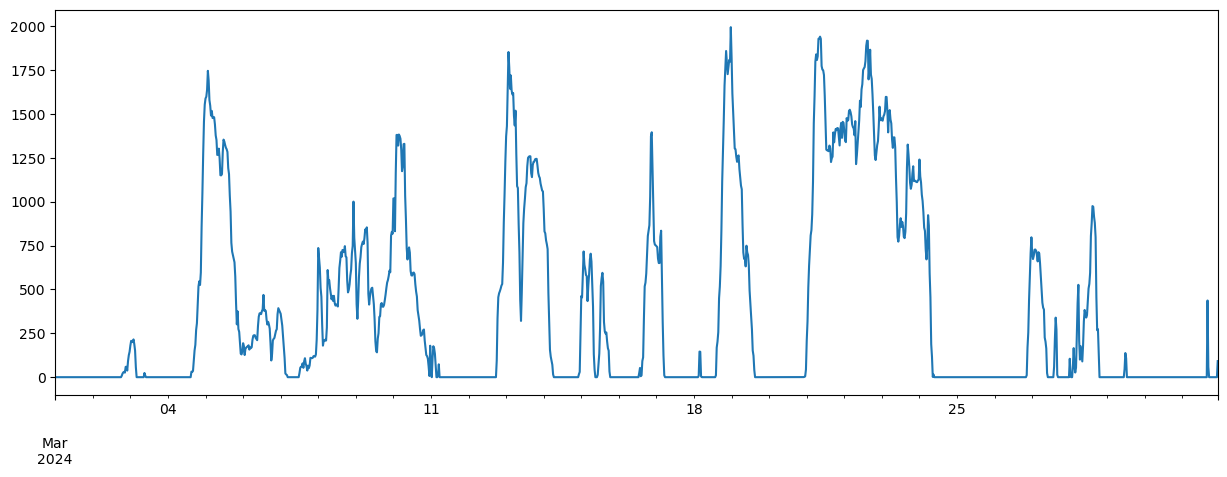

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))

bids.replace(np.nan, 0).sum(axis=1).plot(ax=ax)

plt.show()

In [7]:
nod = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_nodal_solved.nc'
)
nat = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_national_solved.nc'
)
bal = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_national_solved_redispatch.nc'
)

INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units


In [8]:
def set_nested_attr(obj, attr_path, value):
    """
    Sets a nested attribute on an object given an attribute path.

    Parameters:
    - obj: The object on which to set the attribute.
    - attr_path: A string representing the nested attribute path, e.g., 'a.b.c'.
    - value: The value to set for the nested attribute.
    """

    attrs = attr_path.split('.')

    for attr in attrs[:-1]:
        obj = getattr(obj, attr)

    setattr(obj, attrs[-1], value)


In [9]:
supplies = (
    pd.concat((
        nat
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('national'),
        bal
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('balanced'),
        nod
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Supply']
        .rename('nodal'),
    ), axis=1)
    # .drop(index=('Link', 'DC'))
    .drop(index=('Generator', 'local_market'))
    .groupby(level=1)
    .sum()
    .mul(1e-3)
)

withdraws = (
    pd.concat((
        nat
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('national'),
        bal
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('balanced'),
        nod
        .statistics()
        .loc[idx[['Generator', 'StorageUnit', 'Link'], :], 'Withdrawal']
        .rename('nodal'),
        ), axis=1)
    .drop(index=('Link', 'DC'))
    .drop(index=('Generator', 'local_market'))
    .groupby(level=1)
    .sum()
    .mul(-1e-3)
)

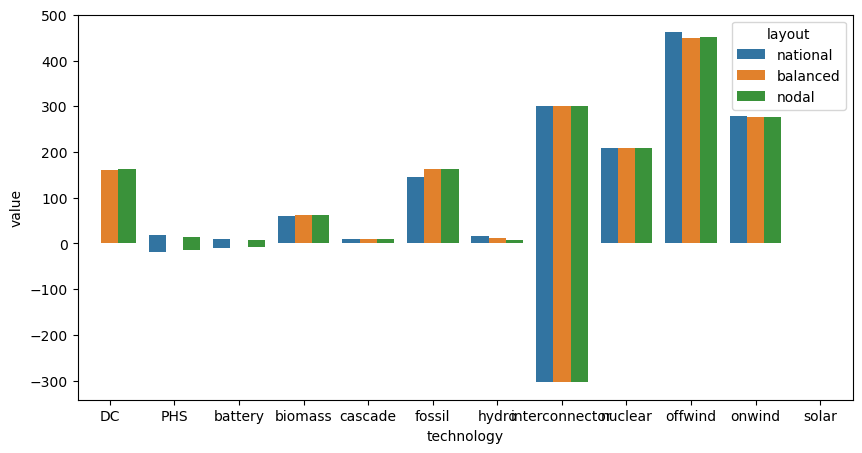

In [10]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

s = supplies.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)

s.drop(s.index[s.technology == 'AC'], inplace=True)
w = withdraws.stack().reset_index().rename(
    columns={
        'level_0': 'technology',
        'level_1': 'layout',
        0: 'value',
        }
)
w.drop(w.index[w.technology == 'AC'], inplace=True)

sns.barplot(
    data=s,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    )

sns.barplot(
    data=w,
    x='technology',
    y='value',
    hue='layout',
    ax=ax,
    legend=False,
    )

plt.show()

In [11]:
bal.statistics()

Optimal Capacity  Installed Capacity  \
Generator   biomass               2028.00000          2028.00000   
            fossil               25331.00000         25331.00000   
            local_market         20640.00000         20640.00000   
            nuclear               4347.00000          4347.00000   
            offwind              11547.48333         11547.48333   
            onwind                6354.51667          6354.51667   
            solar                   53.50000            53.50000   
Link        AC                  873740.82411        873740.82411   
            DC                    3400.00000          3400.00000   
            interconnector       10320.00000         10320.00000   
Load        Belgium                  0.00000             0.00000   
            Denmark                  0.00000             0.00000   
            France                   0.00000             0.00000   
            Netherlands              0.00000             0.00000   
            Norway                   0.00000             0.00000   
            electricity              0.00000             0.00000   
StorageUnit cascade                284.00000           284.00000   
            hydro                  567.00000           567.00000   

                                  Supply    Withdrawal  Energy Balance  \
Generator   biomass         6.204000e+04  0.000000e+00    6.204000e+04   
            fossil          1.630213e+05  0.000000e+00    1.630213e+05   
            local_market    7.549470e+05  0.000000e+00    7.549470e+05   
            nuclear         2.084920e+05  0.000000e+00    2.084920e+05   
            offwind         4.492307e+05  0.000000e+00    4.492307e+05   
            onwind          2.758971e+05  0.000000e+00    2.758971e+05   
            solar           4.555000e+02  0.000000e+00    4.555000e+02   
Link        AC              2.771060e+07  2.771060e+07    0.000000e+00   
            DC              1.613203e+05  1.613203e+05    0.000000e+00   
            interconnector  3.006686e+05  3.032645e+05   -2.595870e+03   
Load        Belgium         0.000000e+00  4.915200e+04   -4.915200e+04   
            Denmark         0.000000e+00  6.720000e+04   -6.720000e+04   
            France          0.000000e+00  2.588640e+05   -2.588640e+05   
            Netherlands     0.000000e+00  5.294400e+04   -5.294400e+04   
            Norway          0.000000e+00  6.720000e+04   -6.720000e+04   
            electricity     1.588695e+04  1.453442e+06   -1.437555e+06   
StorageUnit cascade         1.019578e+04  0.000000e+00    1.019578e+04   
            hydro           1.123167e+04  0.000000e+00    1.123167e+04   

                            Transmission  Capacity Factor   Curtailment  \
Generator   biomass         0.000000e+00         0.637327   24095.50000   
            fossil          0.000000e+00         0.134076  977202.66059   
            local_market    0.000000e+00         0.762019  235773.00000   
            nuclear         0.000000e+00         0.999214       0.00000   
            offwind         0.000000e+00         0.810477   12637.00623   
            onwind          0.000000e+00         0.904531    3749.26821   
            solar           0.000000e+00         0.177375       0.00000   
Link        AC             -4.550452e+06         0.660727       0.00000   
            DC              1.049855e+05         0.988482       0.00000   
            interconnector  0.000000e+00         0.612653       0.00000   
Load        Belgium         0.000000e+00              NaN       0.00000   
            Denmark         0.000000e+00              NaN       0.00000   
            France          0.000000e+00              NaN       0.00000   
            Netherlands     0.000000e+00              NaN       0.00000   
            Norway          0.000000e+00              NaN       0.00000   
            electricity     0.000000e+00              NaN       0.00000   
StorageUnit cascade         0.000000e+00         0.74

In [12]:
lat_bidding_threshold = 55.3 # fossil generators
gen = nod.generators
gen['y'] = gen.bus.map(nod.buses.y)

In [13]:
wind = nod.generators.index[nod.generators.carrier.str.contains('wind')]
water = nod.storage_units.index[nod.storage_units.carrier.isin(['cascade', 'hydro'])]
solar = nod.generators.index[nod.generators.carrier.str.contains('solar')]

dispatchable_south = gen.loc[
    (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
    (gen['y'] <= lat_bidding_threshold)
].index
dispatchable_north = gen.loc[
    (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
    (gen['y'] > lat_bidding_threshold)
].index

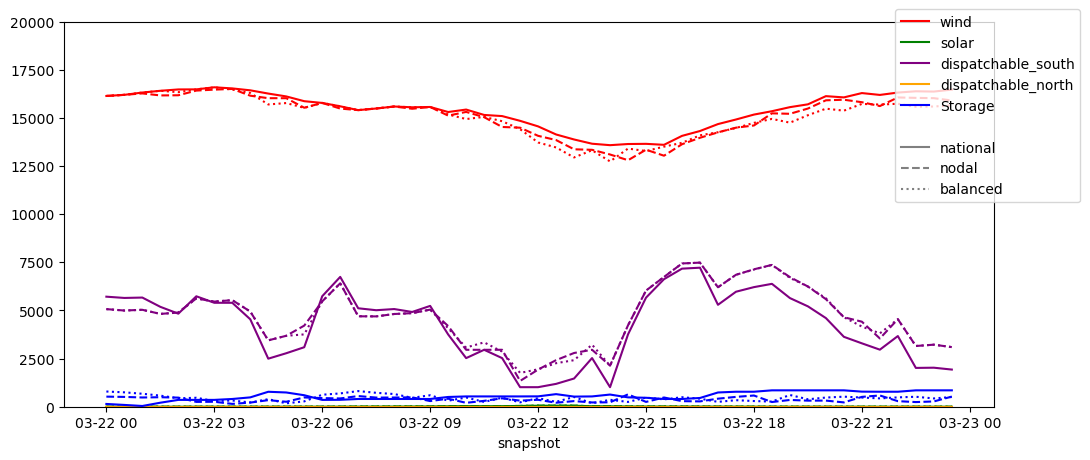

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

labels = []
handles = []

for plants, c, n in zip([
    wind,
    solar,
    dispatchable_south,
    dispatchable_north
    ], ['red', 'green', 'purple', 'orange'],
    ['wind', 'solar', 'dispatchable_south', 'dispatchable_north']):

    sns.lineplot(
        data=nat.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        )
    sns.lineplot(
        data=nod.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        linestyle='dashed',
        )
    sns.lineplot(
        data=bal.generators_t.p[plants].sum(axis=1),
        ax=ax,
        color=c,
        linestyle=':',
        )
    
    labels.append(n)
    handles.append(plt.Line2D([0], [0], color=c))

c = 'blue'
sns.lineplot(
    data=nat.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    )
sns.lineplot(
    data=nod.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    linestyle='dashed',
    )
sns.lineplot(
    data=bal.storage_units_t.p[water].sum(axis=1),
    ax=ax,
    color=c,
    linestyle=':',
    )
    
labels.append('Storage')
handles.append(plt.Line2D([0], [0], color=c))

labels.append('')
handles.append(plt.Line2D([0], [0], color='white'))

labels.append('national')
handles.append(plt.Line2D([0], [0], color='grey'))
labels.append('nodal')
handles.append(plt.Line2D([0], [0], color='grey', linestyle='dashed'))
labels.append('balanced')
handles.append(plt.Line2D([0], [0], color='grey', linestyle=':'))

ax.legend(
    handles, labels,
    loc='upper right', bbox_to_anchor=(1.1, 1.05))

ax.set_ylim(0, 20_000)

plt.show()

In [21]:
nat = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_national_solved.nc'
)
bal = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-22' / 'network_s_national_solved_redispatch.nc'
)


def get_bidding_volume(nat=None, bal=None, day=None):
    """
    Returns the bidding volume of the network.

    Parameters:
        nat(pypsa.Network): The national wholesale market optimum.
        bal(pypsa.Network): The wholesale market after redispatch.
        day(str; yyyy-mm-dd): takes precedent if not None
    """

    if day is not None:
        nat = pypsa.Network(
            Path.cwd().parent / 'results' / f'{day}' / 'network_s_national_solved.nc'
        )
        bal = pypsa.Network(
            Path.cwd().parent / 'results' / f'{day}' / 'network_s_national_solved_redispatch.nc'
        )
    
    else:
        assert nat is not None and bal is not None


    wind = nat.generators.index[nat.generators.carrier.str.contains('wind')]
    water = nat.storage_units.index[nat.storage_units.carrier.isin(['cascade', 'hydro'])]
    solar = nat.generators.index[nat.generators.carrier.str.contains('solar')]

    gen = bal.generators
    gen['y'] = gen.bus.map(bal.buses.y)

    dispatchable_south = gen.loc[
        (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
        (gen['y'] <= lat_bidding_threshold)
    ].index
    dispatchable_north = gen.loc[
        (gen.carrier.isin(['fossil', 'biomass', 'coal'])) &
        (gen['y'] > lat_bidding_threshold)
    ].index

    bidding_volume = pd.Series(0, nat.snapshots)

    for plant in [wind, solar, dispatchable_south, dispatchable_north]:
        
        bidding_volume += (
            nat.generators_t.p[plant].sum(axis=1) -
            bal.generators_t.p[plant].sum(axis=1)
        ).clip(lower=0)
    
    bidding_volume += (
        nat.storage_units_t.p[water].sum(axis=1) -
        bal.storage_units_t.p[water].sum(axis=1)
    ).clip(lower=0)
    
    return bidding_volume


INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units


In [77]:
bidding_vol = []

for day in pd.date_range('2024-03-01', '2024-03-25', freq='d'):
    day = day.strftime('%Y-%m-%d')
    bidding_vol.append(get_bidding_volume(day=day))

INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_s_national_solved_redispatch.nc has buses, carriers, generators, links, loads, st

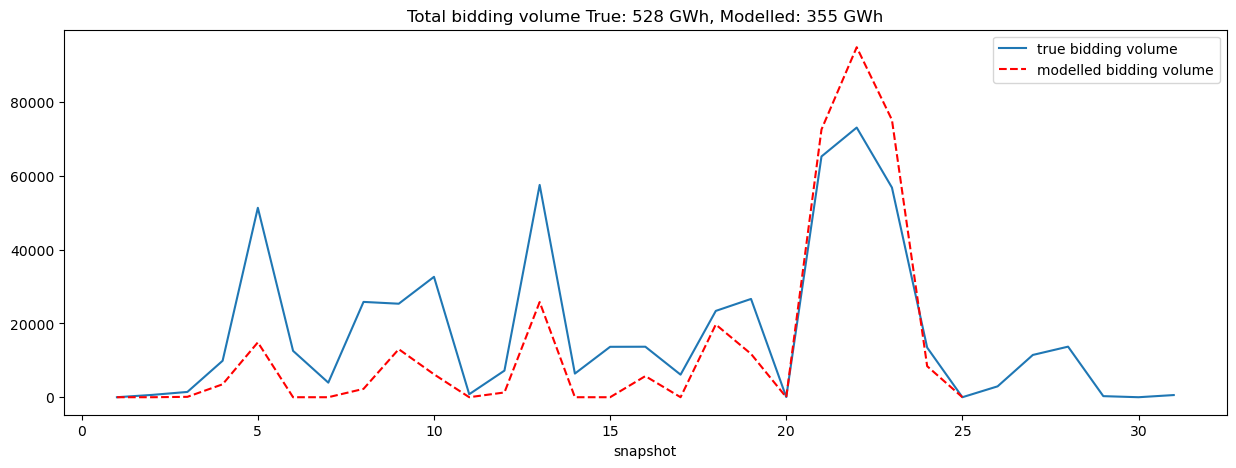

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))

bids.replace(np.nan, 0).sum(axis=1).groupby(bids.index.day).sum().plot(ax=ax, label='true bidding volume')

(
    (b := pd.concat(bidding_vol))
    .groupby(b.index.day).sum()
    .plot(ax=ax, color='red', linestyle='dashed', label='modelled bidding volume')
)

b.index = pd.to_datetime(b.index, utc=True)

ax.set_title(
    (
        "Total bidding volume "
        f"True: {bids.replace(np.nan, 0).sum(axis=1).loc[b.index[0]:b.index[-1]].mul(1e-3).sum():.0f} GWh, "
        f"Modelled: {b.mul(1e-3).sum():.0f} GWh"
    )
)

plt.legend()
# ax.set_xlim('2024-03-14 12:00', '2024-03-30 00:00')

plt.show()

In [70]:
import geopandas as gpd

zonal = gpd.read_file(Path.cwd().parent / 'data' / 'eso_zones.geojson').set_index('name')
zonal['centroid_lat'] = zonal.geometry.centroid.y
zonal.sort_values('centroid_lat', ascending=False, inplace=True)
zonal

,geometry,centroid_lat
name,,
GB0 Z1_1,"MULTIPOLYGON (((-1.60814 59.54735, -1.61042 59...",60.377480
GB0 Z1_3,"MULTIPOLYGON (((-3.34789 58.65204, -3.34057 58...",58.107875
GB0 Z1_2,"MULTIPOLYGON (((-7.38199 56.98753, -7.37352 56...",57.944564
GB0 Z2,"POLYGON ((-3.09422 57.67233, -3.07868 57.66942...",57.182664
GB0 Z1_4,"MULTIPOLYGON (((-6.16002 56.46955, -6.21247 56...",57.119940
GB0 Z3,"MULTIPOLYGON (((-5.00939 55.72932, -5.01618 55...",56.442002
GB0 Z4,"MULTIPOLYGON (((-5.11779 55.43976, -5.16356 55...",55.779896
GB0 Z5,"POLYGON ((-2.57681 56.28075, -2.57681 56.27778...",55.777926
GB0 Z6,"POLYGON ((-2.14293 55.91612, -2.13801 55.91462...",55.264882


In [74]:
zone_grouper = {
    1: ['GB0 Z1_1', 'GB0 Z1_2', 'GB0 Z1_3', 'GB0 Z1_4', 'GB0 Z2'],
    2: ['GB0 Z3', 'GB0 Z4', 'GB0 Z5', 'GB0 Z6'],
    3: ['GB0 Z7'],
    4: ['GB0 Z8', 'GB0 Z9', 'GB0 Z10', 'GB0 Z11', 'GB0 Z12', 'GB0 Z14'],
    5: ['GB0 Z13'],
    6: ['GB0 Z17', 'GB0 Z16', 'GB0 Z15'],
}

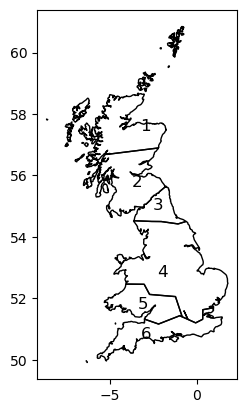

In [106]:
new_zones = gpd.GeoDataFrame(index=[], geometry=[], crs=zonal.crs)

for key, zones in zone_grouper.items():
    new_zones.loc[key, 'geometry'] = zonal.loc[zones].unary_union

new_zones.plot(facecolor='none', edgecolor='black')

for idx, row in new_zones.iterrows():

    point = row['geometry'].representative_point()
    x, y = point.x, point.y
    plt.text(x, y, idx, fontsize=12, ha='center', va='center')

In [91]:
buses = pypsa.Network(Path.cwd().parent / 'results' / '2024-03-22' / 'network.nc').buses

INFO:pypsa.io:Imported network network.nc has buses, carriers, generators, lines, links, loads, storage_units, transformers


In [93]:
ss = bmus.loc[
    (bmus['lat'] != 'distributed') &
    (bmus['lat'] != 0)
]
bm_gpd = gpd.GeoDataFrame(ss[[]], geometry=gpd.points_from_xy(
    buses.loc[ss.bus, 'x'].values,
    buses.loc[ss.bus, 'y'].values,
    ),
    crs='EPSG:4326')
bm_gpd = bm_gpd.sjoin(new_zones, how='left')


In [95]:
import seaborn as sns

grouped_bids = bids.replace(np.nan, 0).groupby(bids.index.day).sum().T
grouped_bids = grouped_bids.groupby(grouped_bids.index.map(lambda x: bm_gpd.loc[x, 'index_right'])).sum()

<Axes: >

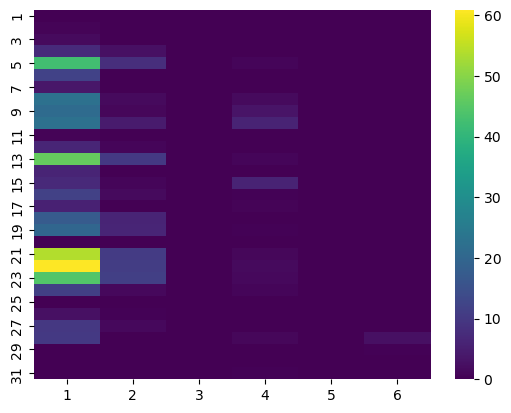

In [98]:
sns.heatmap(grouped_bids.mul(1e-3).T, cmap='viridis')

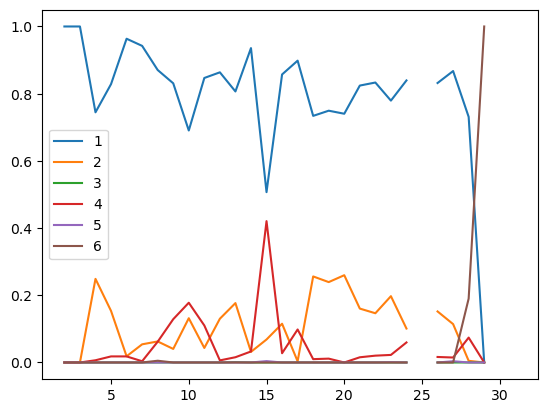

In [103]:
for i in grouped_bids.index:
    (grouped_bids.loc[i] / grouped_bids.sum()).plot(label=i)
plt.legend()

<Axes: xlabel='Generator'>

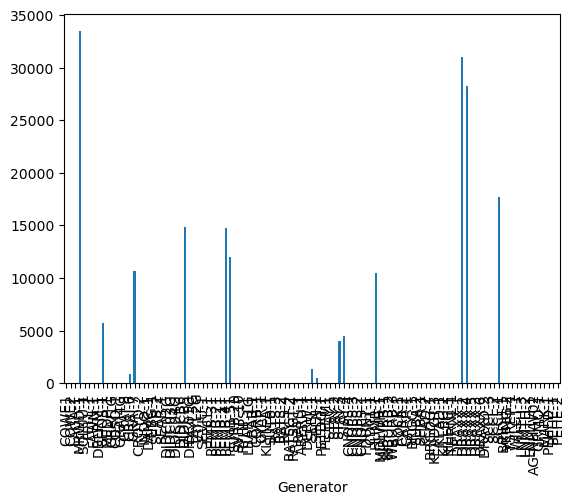

In [31]:
natn.generators_t.p[nplants].sum().plot.bar()

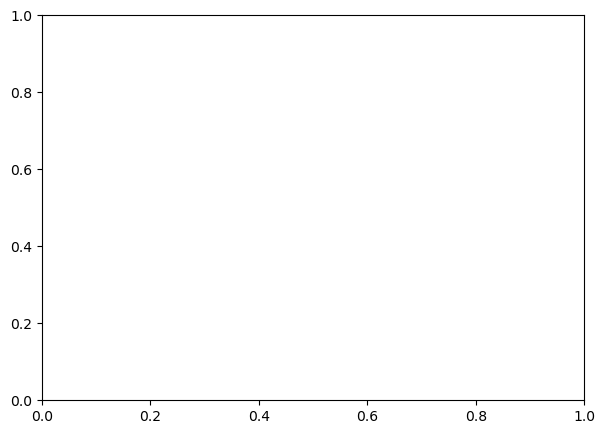

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))



plt.show()

In [51]:
natn.buses.loc[natn.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country
Bus,,,,,,,,,,,,,
Belgium,380.0,,3.12,51.23,electricity,,1.0,0.0,inf,Slack,belgium_local_market,,Belgium
Denmark,380.0,,8.40,55.43,electricity,,1.0,0.0,inf,Slack,denmark_local_market,,Denmark
France,380.0,,-1.71,49.64,electricity,,1.0,0.0,inf,Slack,france_local_market,,France
Netherlands,380.0,,3.56,51.53,electricity,,1.0,0.0,inf,Slack,netherlands_local_market,,Netherlands
Norway,380.0,,5.50,59.02,electricity,,1.0,0.0,inf,Slack,norway_local_market,,Norway


In [40]:
ns.buses.loc[ns.buses.country != 'GB']

,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,tags,under_construction,country,symbol,substation_lv,substation_off
Bus,,,,,,,,,,,,,,,,,,
Netherlands,1.0,,3.56,51.53,electricity,,1.0,0.0,inf,PQ,,,,NaN,Netherlands,,NaN,NaN
France,1.0,,-1.71,49.64,electricity,,1.0,0.0,inf,PQ,,,,NaN,France,,NaN,NaN
Belgium,1.0,,3.12,51.23,electricity,,1.0,0.0,inf,PQ,,,,NaN,Belgium,,NaN,NaN
Denmark,1.0,,8.40,55.43,electricity,,1.0,0.0,inf,PQ,,,,NaN,Denmark,,NaN,NaN
Norway,1.0,,5.50,59.02,electricity,,1.0,0.0,inf,PQ,,,,NaN,Norway,,NaN,NaN


In [37]:
ns.links

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,tags,under_construction,geometry,underground,underwater_fraction
Link,,,,,,,,,,,,,,,,,,,,,
8009,5896,5939,,DC,1.00,True,0,inf,2200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""70191"", ""...",0.0,"LINESTRING(-3.18595885129092 53.213699479605,-...",0.0,0.979689
8708,6443,6448,,DC,1.00,True,0,inf,1200.0,0.0,...,NaN,NaN,1.0,1.0,0.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""115391"", ...",0.0,"LINESTRING(-3.45338156475634 58.4908032474467,...",0.0,0.583200
IFA1,France,4977,,interconnector,0.99,True,0,inf,2000.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
IFA2,France,4955,,interconnector,0.99,True,0,inf,2116.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
ElecLink,France,5269,,interconnector,0.99,True,0,inf,1277.0,0.0,...,NaN,NaN,1.0,1.0,0.0,,NaN,,NaN,NaN
